In [14]:
# %% [markdown]
# # 📊 Análise de Desempenho: Fortran vs Rust
# 
# Este notebook realiza uma análise estatística e visual dos resultados
# coletados via `perf` para os algoritmos de triangulação.
# 
# Ele considera as versões:
# - Sequencial em Fortran
# - Sequencial em Rust
# - Paralelo em Rust (com diferentes números de threads)
# 
# O notebook calcula estatísticas, gera gráficos e computa métricas
# de speedup e eficiência paralela.

# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [15]:
# Configurações gráficas
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)

# %%
# 📂 Lê o CSV consolidado
df = pd.read_csv("../Extract Perf Data/dados_perf_consolidados.csv")
df.fillna(0, inplace=True)

print("✅ CSV carregado com sucesso!")
print("Colunas disponíveis:", df.columns.tolist())
print(f"Total de registros: {len(df)}")

✅ CSV carregado com sucesso!
Colunas disponíveis: ['linguagem', 'tipo', 'threads', 'arquivo_entrada', 'arquivo', 'caso', 'versao_do_codigo', 'cpu_clock', 'cycles', 'cache_misses', 'cache_refs', 'branch_misses', 'branches', 'page_faults', 'time_elapsed', 'user_time', 'sys_time']
Total de registros: 4200


In [16]:
# %%
# 🔍 Normaliza colunas numéricas
df["threads"] = df["threads"].astype(int)
df["caso"] = df["caso"].astype(int)
df["time_elapsed"] = df["time_elapsed"].astype(float)

In [17]:
# %%
# 🧮 Calcula média e desvio padrão por combinação (linguagem, tipo, entrada, threads)
group_cols = ["linguagem", "tipo", "arquivo_entrada", "threads", "versao_do_codigo"]
agg_cols = ["cpu_clock", "cycles", "cache_misses", "time_elapsed", "user_time", "sys_time"]

df_stats = df.groupby(group_cols)[agg_cols].agg(["mean", "std"]).reset_index()

print("✅ Estatísticas agregadas calculadas!")
df_stats.head()

✅ Estatísticas agregadas calculadas!


linguagem        tipo arquivo_entrada threads       versao_do_codigo  \
                                                                         
0   Fortran  Sequencial         100_000       1                General   
1   Fortran  Sequencial         100_000       1  General_without_Print   
2   Fortran  Sequencial          10_000       1                General   
3   Fortran  Sequencial          10_000       1  General_without_Print   
4   Fortran  Sequencial           1_000       1                General   

    cpu_clock                      cycles                cache_misses  \
         mean           std          mean           std          mean   
0  676394.603  11851.373716  2.606983e+12  4.693669e+10  8.344085e+10   
1  687245.087  11853.555382  2.649351e+12  4.656355e+10  8.391404e+10   
2    4271.755     11.429572  1.643406e+10  3.824997e+07  9.155422e+05   
3    4275.907      5.591227  1.645036e+10  2.905696e+07  9.035203e+05   
4     461.868      1.962327  1.720097e+09  2.060338e+06  8.739150e+04   

                time_elapsed              user_time             sys_time  \
            std         mean        std        mean        std      mean   
0  7.184949e+08   676.949932  11.867143  676.044632  11.768249  0.330244   
1  4.190025e+08   687.372737  11.875743  687.058364  11.811503  0.164867   
2  1.478967e+04     4.402657   0.009658    4.251970   0.012477  0.021257   
3  1.744406e+04     4.407853   0.007803    4.253625   0.006067  0.023646   
4  3.604334e+03     0.463097   0.001998    0.459371   0.003208  0.003799   

             
        std  
0  0.126979  
1  0.067546  
2  0.004796  
3  0.003190  
4  0.001477

C:\Users\danie\AppData\Local\Temp\ipykernel_33648\1910525255.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


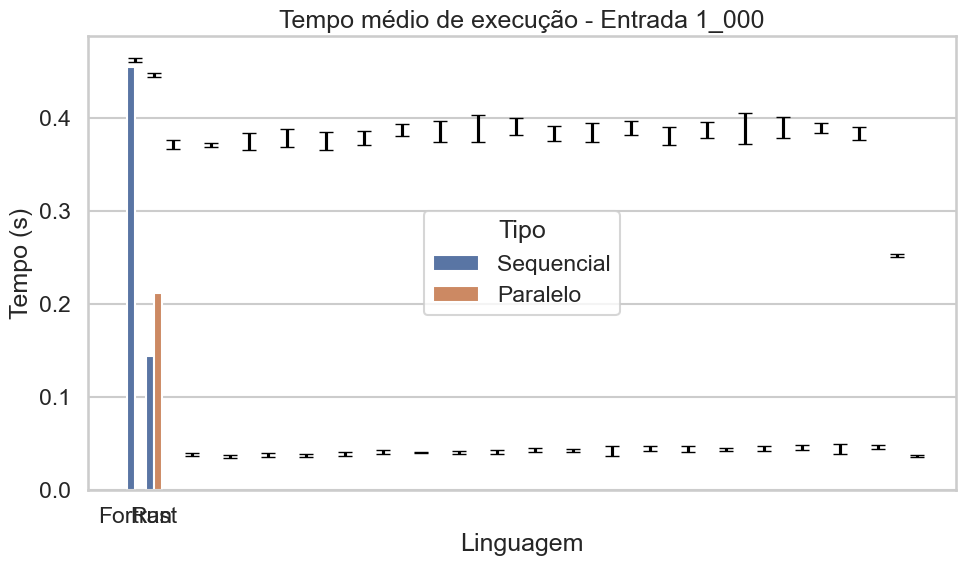

C:\Users\danie\AppData\Local\Temp\ipykernel_33648\1910525255.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


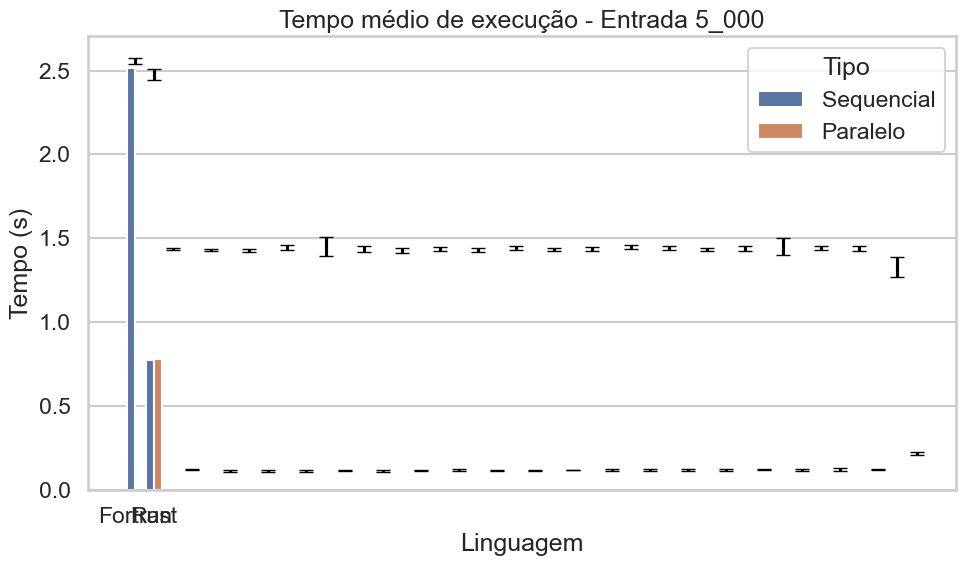

C:\Users\danie\AppData\Local\Temp\ipykernel_33648\1910525255.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


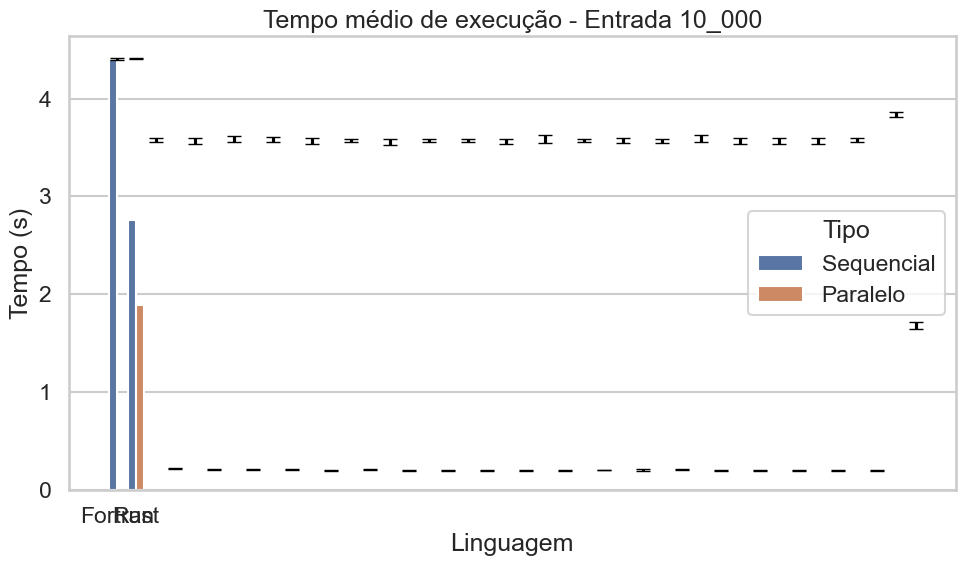

C:\Users\danie\AppData\Local\Temp\ipykernel_33648\1910525255.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


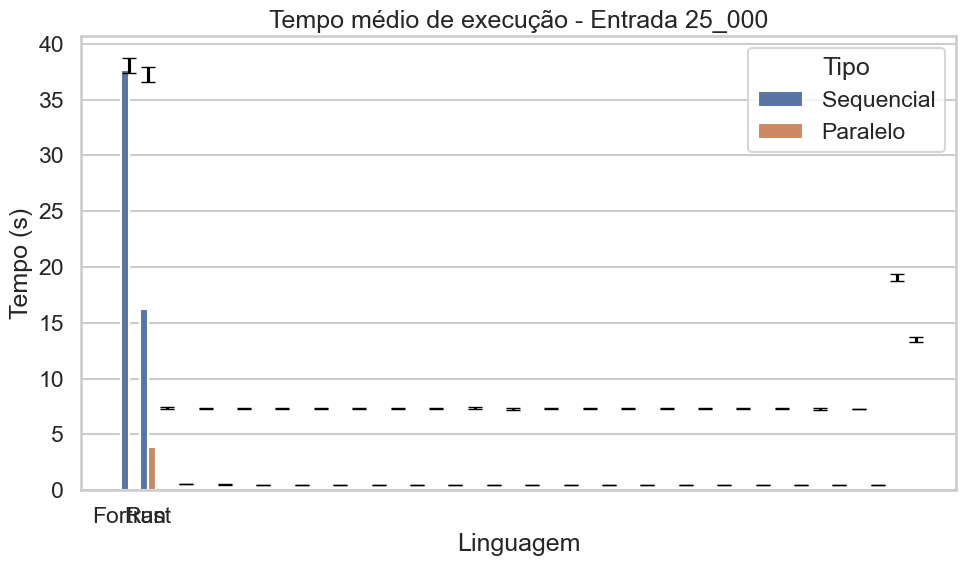

C:\Users\danie\AppData\Local\Temp\ipykernel_33648\1910525255.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


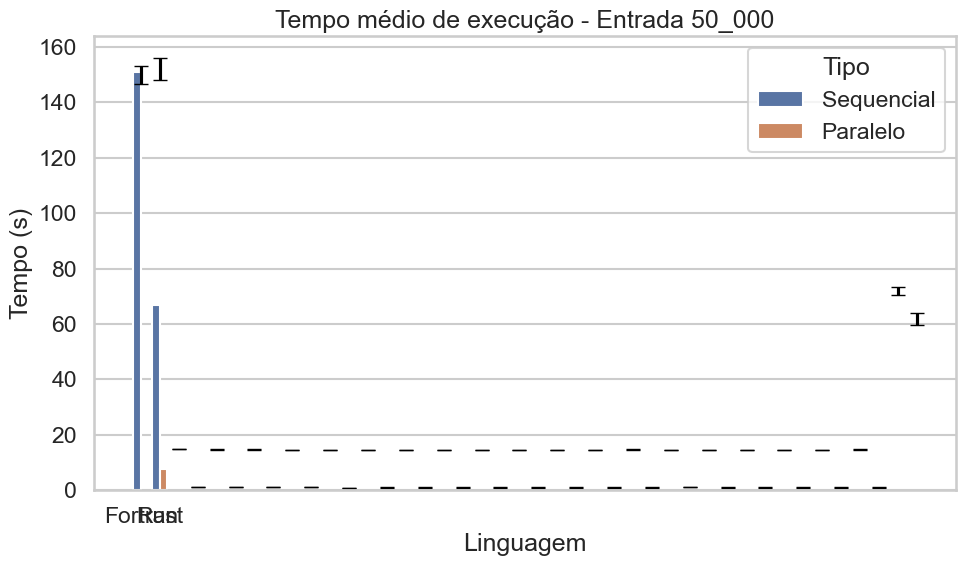

C:\Users\danie\AppData\Local\Temp\ipykernel_33648\1910525255.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


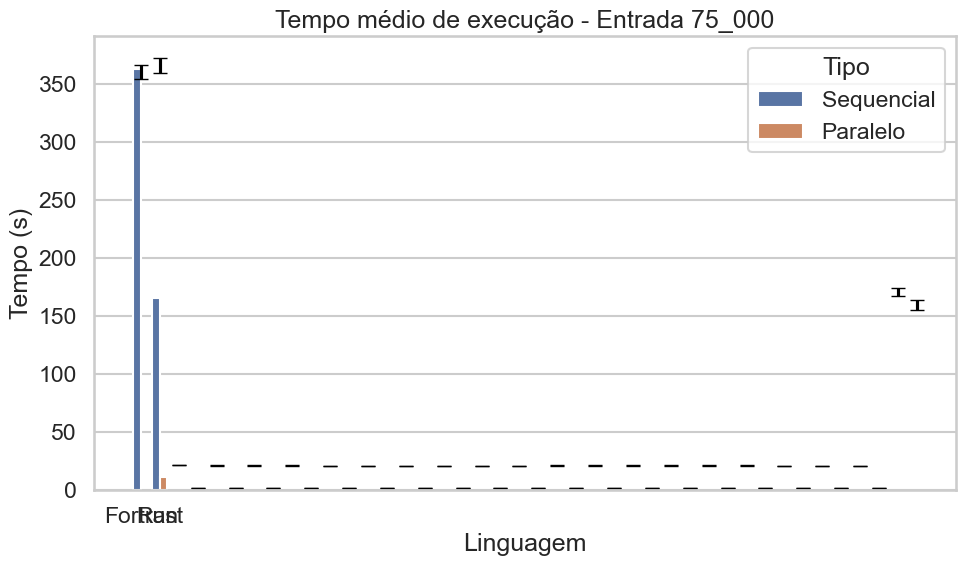

C:\Users\danie\AppData\Local\Temp\ipykernel_33648\1910525255.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


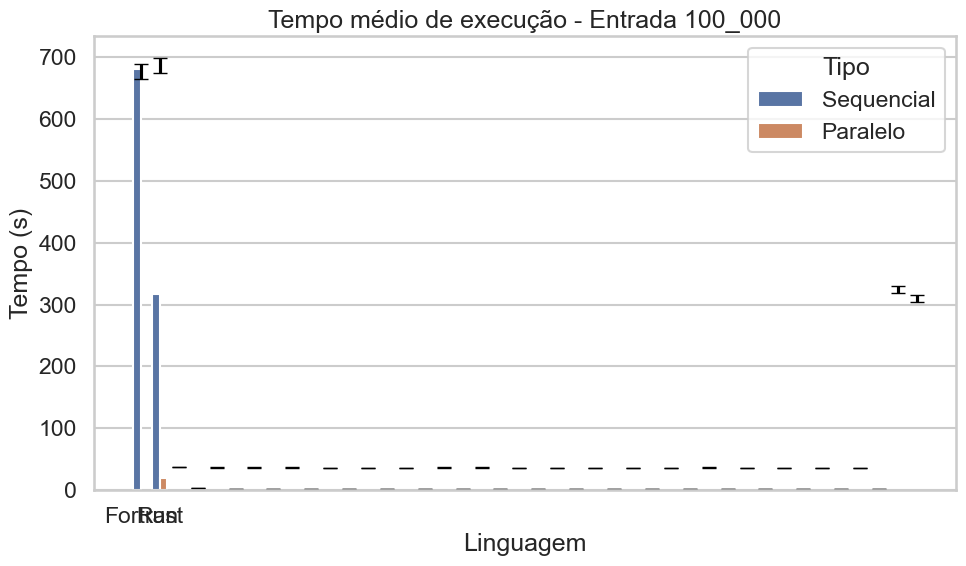

C:\Users\danie\AppData\Local\Temp\ipykernel_33648\1910525255.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


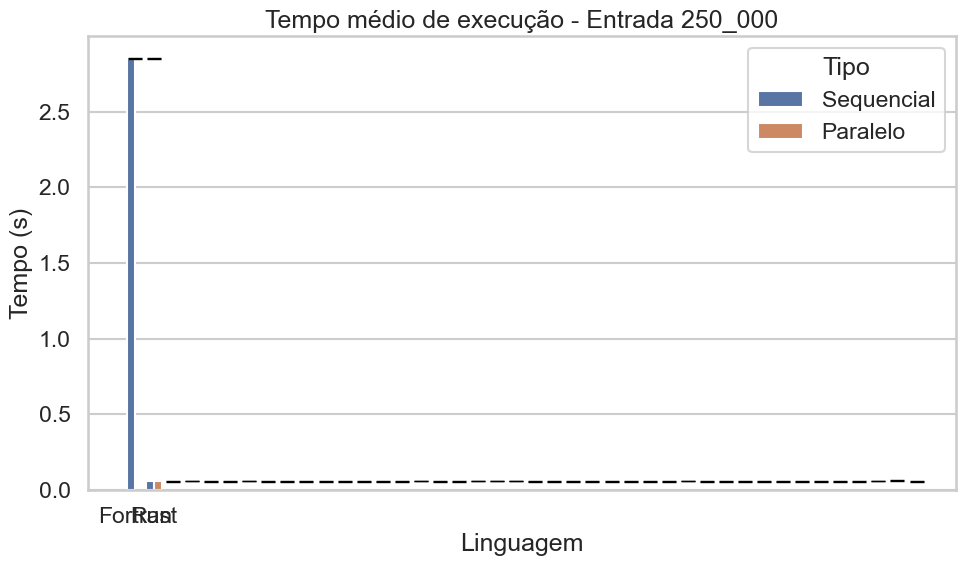

C:\Users\danie\AppData\Local\Temp\ipykernel_33648\1910525255.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


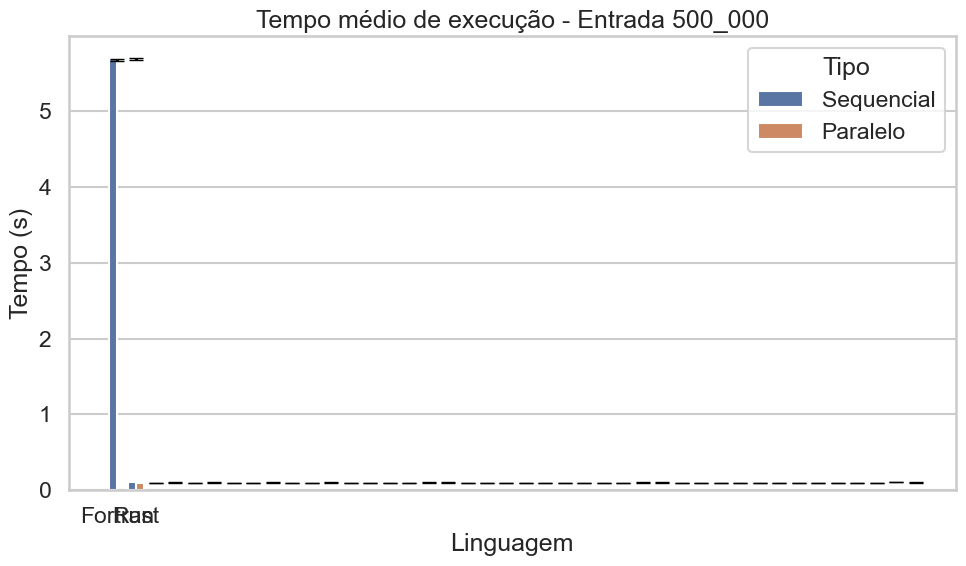

C:\Users\danie\AppData\Local\Temp\ipykernel_33648\1910525255.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


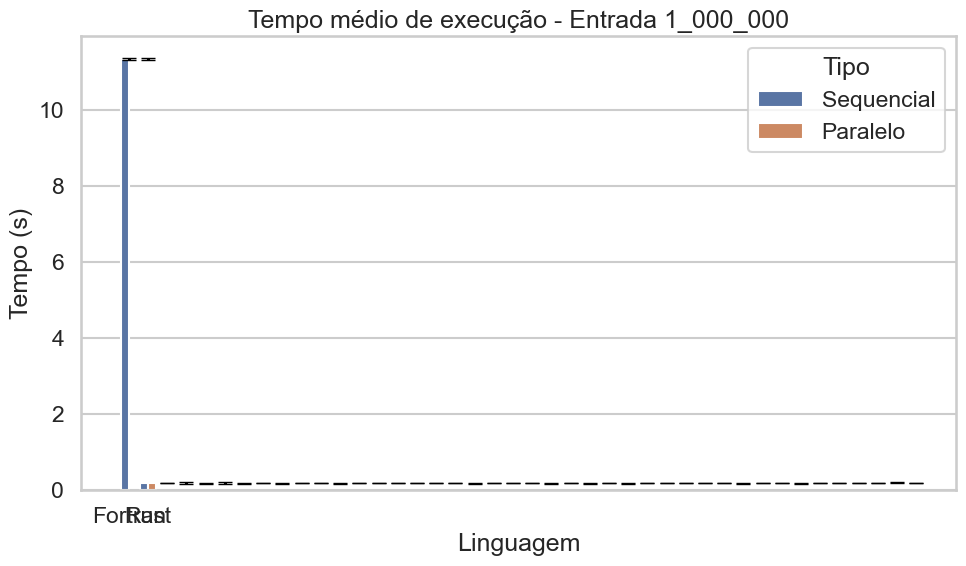

In [18]:
# %%
# --- Gráfico 1: Tempo médio de execução por versão ---
for entrada in sorted(df_stats["arquivo_entrada"].unique(), key=lambda x: int(x.replace("_", ""))):
    subset = df_stats[df_stats["arquivo_entrada"] == entrada]

    plt.figure()
    sns.barplot(
        data=subset,
        x="linguagem",
        y=("time_elapsed", "mean"),
        hue="tipo",
        ci=None
    )
    plt.errorbar(
        x=np.arange(len(subset)),
        y=subset[("time_elapsed", "mean")],
        yerr=subset[("time_elapsed", "std")],
        fmt='none',
        c='black',
        capsize=5
    )
    plt.title(f"Tempo médio de execução - Entrada {entrada}")
    plt.ylabel("Tempo (s)")
    plt.xlabel("Linguagem")
    plt.legend(title="Tipo")
    plt.tight_layout()
    plt.savefig(f"grafico_tempo_{entrada}.png", dpi=300)
    plt.show()

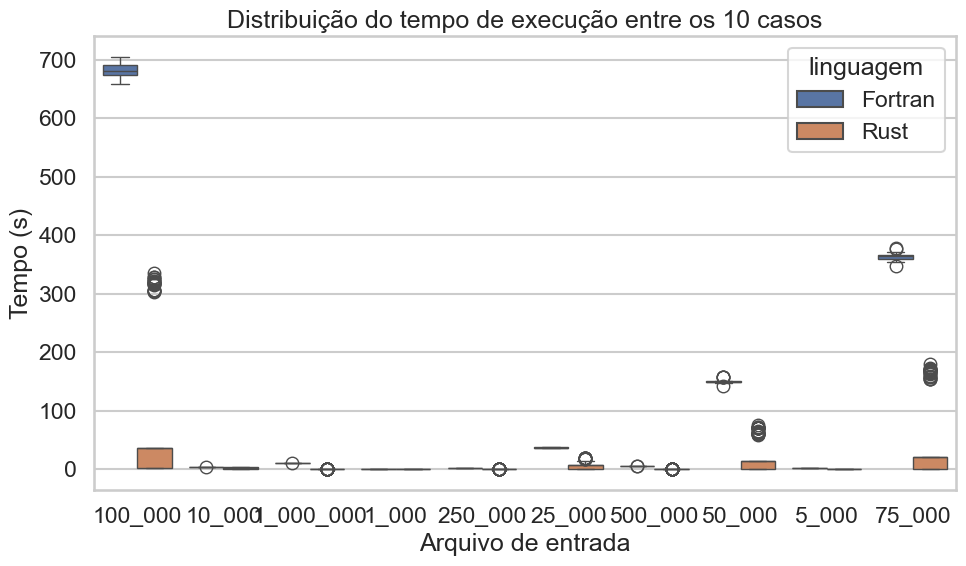

In [19]:
# %%
# --- Gráfico 2: Distribuição de tempos entre as 10 execuções (boxplot) ---
plt.figure()
sns.boxplot(
    data=df,
    x="arquivo_entrada",
    y="time_elapsed",
    hue="linguagem"
)
plt.title("Distribuição do tempo de execução entre os 10 casos")
plt.xlabel("Arquivo de entrada")
plt.ylabel("Tempo (s)")
plt.tight_layout()
plt.savefig("grafico_boxplot_variacao_execucoes.png", dpi=300)
plt.show()

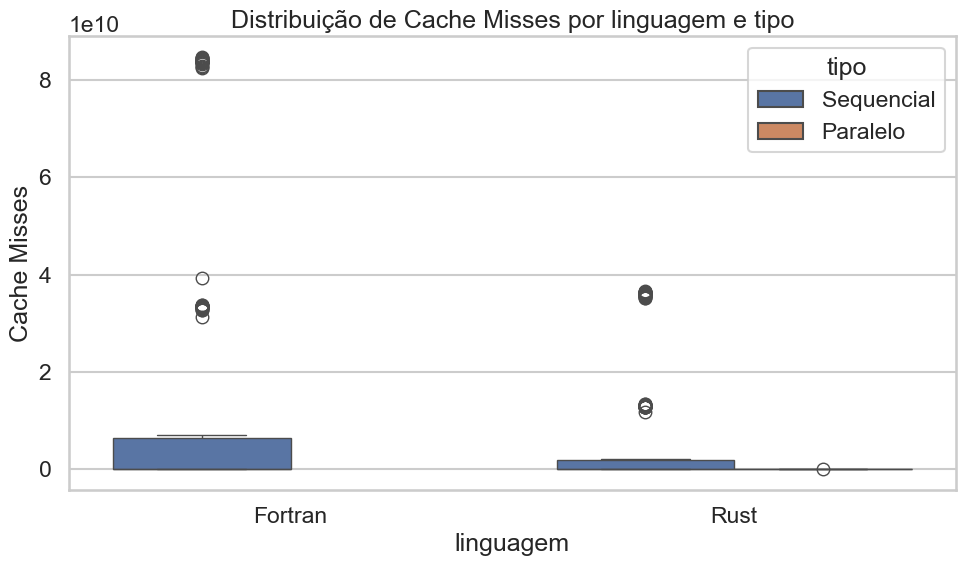

In [20]:
# %%
# --- Gráfico 3: Cache Misses por versão ---
plt.figure()
sns.boxplot(
    data=df,
    x="linguagem",
    y="cache_misses",
    hue="tipo"
)
plt.title("Distribuição de Cache Misses por linguagem e tipo")
plt.ylabel("Cache Misses")
plt.tight_layout()
plt.savefig("grafico_cache_misses.png", dpi=300)
plt.show()

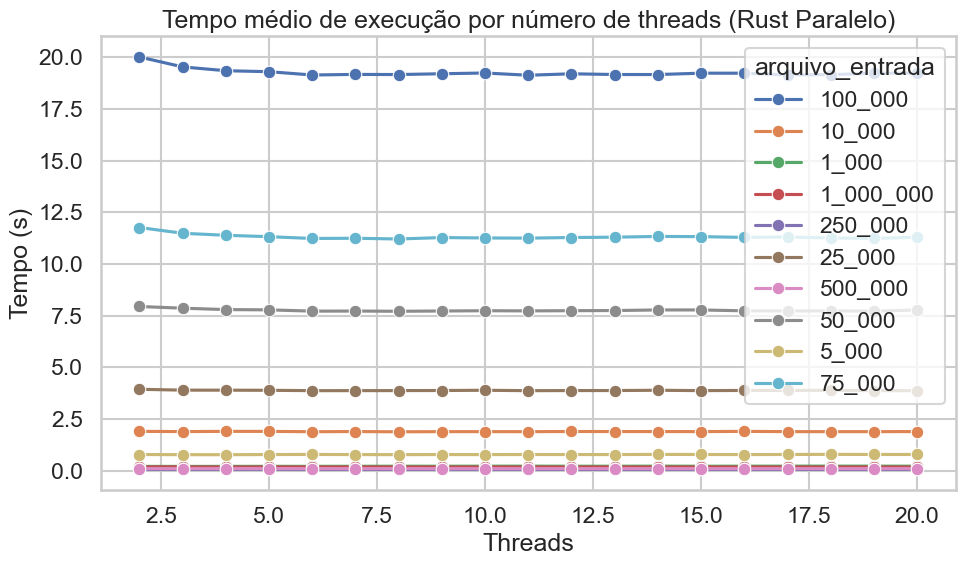

In [21]:
# %%
# --- Gráfico 4: Tempo de execução por número de threads (Rust Paralelo) ---
df_paralelo = df[df["tipo"] == "Paralelo"]

if not df_paralelo.empty:
    plt.figure()
    sns.lineplot(
        data=df_paralelo.groupby(["threads", "arquivo_entrada"], as_index=False)["time_elapsed"].mean(),
        x="threads",
        y="time_elapsed",
        hue="arquivo_entrada",
        marker="o"
    )
    plt.title("Tempo médio de execução por número de threads (Rust Paralelo)")
    plt.xlabel("Threads")
    plt.ylabel("Tempo (s)")
    plt.tight_layout()
    plt.savefig("grafico_threads_tempo.png", dpi=300)
    plt.show()

In [22]:
# %%
# --- Gráfico 5: Cálculo de Speedup e Eficiência Paralela (Rust) ---
df_seq_rust = df_stats[(df_stats["linguagem"] == "Rust") & (df_stats["tipo"] == "Sequencial")][["arquivo_entrada", ("time_elapsed", "mean")]]
df_par_rust = df_stats[(df_stats["linguagem"] == "Rust") & (df_stats["tipo"] == "Paralelo")][["arquivo_entrada", "threads", ("time_elapsed", "mean")]]

df_seq_rust.columns = ["arquivo_entrada", "tempo_seq"]
df_par_rust.columns = ["arquivo_entrada", "threads", "tempo_par"]

# Junta as tabelas para calcular speedup
df_speedup = pd.merge(df_par_rust, df_seq_rust, on="arquivo_entrada", how="inner")
df_speedup["speedup"] = df_speedup["tempo_seq"] / df_speedup["tempo_par"]
df_speedup["eficiencia"] = df_speedup["speedup"] / df_speedup["threads"]

# Mostra a tabela resumo
print("📈 Speedup e Eficiência:")
display(df_speedup.head())

KeyError: "[('time_elapsed', 'mean')] not in index"

In [ ]:
# %%
# --- Gráfico 6: Speedup por número de threads ---
plt.figure()
sns.lineplot(
    data=df_speedup,
    x="threads",
    y="speedup",
    hue="arquivo_entrada",
    marker="o"
)
plt.title("Speedup em função do número de threads (Rust Paralelo)")
plt.xlabel("Threads")
plt.ylabel("Speedup")
plt.tight_layout()
plt.savefig("grafico_speedup_threads.png", dpi=300)
plt.show()

In [ ]:
# %%
# --- Gráfico 7: Eficiência paralela ---
plt.figure()
sns.lineplot(
    data=df_speedup,
    x="threads",
    y="eficiencia",
    hue="arquivo_entrada",
    marker="o"
)
plt.title("Eficiência paralela em função do número de threads (Rust Paralelo)")
plt.xlabel("Threads")
plt.ylabel("Eficiência (Speedup / Threads)")
plt.tight_layout()
plt.savefig("grafico_eficiencia_threads.png", dpi=300)
plt.show()

# %%
print("✅ Análises concluídas e gráficos salvos com sucesso!")